STAT 453: Deep Learning (Spring 2021)  
Instructor: Sebastian Raschka (sraschka@wisc.edu)  

Course website: http://pages.stat.wisc.edu/~sraschka/teaching/stat453-ss2021/  
GitHub repository: https://github.com/rasbt/stat453-deep-learning-ss21

---

# Convolutional Variational Autoencoder for CelebA Face Images

In [21]:
#%load_ext watermark
#%watermark -a 'Sebastian Raschka' -v -p torch

## Imports

In [22]:
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

#### Import utility functions

In [23]:
from helper_data import get_dataloaders_celeba
from helper_data import UnNormalize
from helper_train import train_vae_v1
from helper_utils import set_deterministic, set_all_seeds
from helper_plotting import plot_accuracy, plot_training_loss
from helper_plotting import plot_generated_images
from helper_plotting import plot_latent_space_with_labels
from helper_plotting import plot_images_sampled_from_vae

In [24]:
##########################
### SETTINGS
##########################

# Device
CUDA_DEVICE_NUM = 0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
NUM_EPOCHS = 50

Device: cuda:0


In [25]:
set_deterministic
set_all_seeds(RANDOM_SEED)

## Dataset

In [26]:
##########################
### Dataset
##########################


custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_loader, valid_loader, test_loader = get_dataloaders_celeba(
    batch_size=BATCH_SIZE,
    train_transforms=custom_transforms,
    test_transforms=custom_transforms,
    num_workers=2)

Files already downloaded and verified


In [27]:
# Checking the dataset
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
    
# Checking the dataset
print('\nValidation Set:')
for images, labels in valid_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

# Checking the dataset
print('\nTesting Set:')
for images, labels in test_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break
    
"""Targets are 40-dim vectors representing
00 - 5_o_Clock_Shadow
01 - Arched_Eyebrows
02 - Attractive 
03 - Bags_Under_Eyes
04 - Bald
05 - Bangs
06 - Big_Lips
07 - Big_Nose
08 - Black_Hair
09 - Blond_Hair
10 - Blurry 
11 - Brown_Hair 
12 - Bushy_Eyebrows 
13 - Chubby 
14 - Double_Chin 
15 - Eyeglasses 
16 - Goatee 
17 - Gray_Hair 
18 - Heavy_Makeup 
19 - High_Cheekbones 
20 - Male 
21 - Mouth_Slightly_Open 
22 - Mustache 
23 - Narrow_Eyes 
24 - No_Beard 
25 - Oval_Face 
26 - Pale_Skin 
27 - Pointy_Nose 
28 - Receding_Hairline 
29 - Rosy_Cheeks 
30 - Sideburns 
31 - Smiling 
32 - Straight_Hair 
33 - Wavy_Hair 
34 - Wearing_Earrings 
35 - Wearing_Hat 
36 - Wearing_Lipstick 
37 - Wearing_Necklace 
38 - Wearing_Necktie 
39 - Young         
"""

Training Set:

Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])

Validation Set:
Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])

Testing Set:
Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256, 40])


'Targets are 40-dim vectors representing\n00 - 5_o_Clock_Shadow\n01 - Arched_Eyebrows\n02 - Attractive \n03 - Bags_Under_Eyes\n04 - Bald\n05 - Bangs\n06 - Big_Lips\n07 - Big_Nose\n08 - Black_Hair\n09 - Blond_Hair\n10 - Blurry \n11 - Brown_Hair \n12 - Bushy_Eyebrows \n13 - Chubby \n14 - Double_Chin \n15 - Eyeglasses \n16 - Goatee \n17 - Gray_Hair \n18 - Heavy_Makeup \n19 - High_Cheekbones \n20 - Male \n21 - Mouth_Slightly_Open \n22 - Mustache \n23 - Narrow_Eyes \n24 - No_Beard \n25 - Oval_Face \n26 - Pale_Skin \n27 - Pointy_Nose \n28 - Receding_Hairline \n29 - Rosy_Cheeks \n30 - Sideburns \n31 - Smiling \n32 - Straight_Hair \n33 - Wavy_Hair \n34 - Wearing_Earrings \n35 - Wearing_Hat \n36 - Wearing_Lipstick \n37 - Wearing_Necklace \n38 - Wearing_Necktie \n39 - Young         \n'

## Model

In [28]:
##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :128, :128]


class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
                nn.Conv2d(3, 32, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(4096, 200)
        self.z_log_var = torch.nn.Linear(4096, 200)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(200, 4096),
                Reshape(-1, 64, 8, 8),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(0.1, inplace=True),
                nn.Dropout2d(0.25),
                #
                nn.ConvTranspose2d(32, 3, stride=2, kernel_size=3, padding=1),
                #
                Trim(),  # 3x129x129 -> 3x128x128
                nn.Sigmoid()
                )


    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded

        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [29]:
set_all_seeds(RANDOM_SEED)

model = VAE()
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)  

## Training

In [30]:
log_dict = train_vae_v1(num_epochs=NUM_EPOCHS, model=model, 
                        optimizer=optimizer, device=DEVICE, 
                        train_loader=train_loader,
                        skip_epoch_stats=True,
                        logging_interval=50,
                        save_model='vae_celeba_02.pt')

Epoch: 001/050 | Batch 0000/0636 | Loss: 5469.2363
Epoch: 001/050 | Batch 0050/0636 | Loss: 2132.9031
Epoch: 001/050 | Batch 0100/0636 | Loss: 1488.5073
Epoch: 001/050 | Batch 0150/0636 | Loss: 1219.1448
Epoch: 001/050 | Batch 0200/0636 | Loss: 1063.8699
Epoch: 001/050 | Batch 0250/0636 | Loss: 1034.0071
Epoch: 001/050 | Batch 0300/0636 | Loss: 941.1235
Epoch: 001/050 | Batch 0350/0636 | Loss: 979.1281
Epoch: 001/050 | Batch 0400/0636 | Loss: 933.8757
Epoch: 001/050 | Batch 0450/0636 | Loss: 916.6193
Epoch: 001/050 | Batch 0500/0636 | Loss: 918.9703
Epoch: 001/050 | Batch 0550/0636 | Loss: 865.5564
Epoch: 001/050 | Batch 0600/0636 | Loss: 847.1504
Time elapsed: 5.22 min
Epoch: 002/050 | Batch 0000/0636 | Loss: 827.7183
Epoch: 002/050 | Batch 0050/0636 | Loss: 798.7646
Epoch: 002/050 | Batch 0100/0636 | Loss: 827.0720
Epoch: 002/050 | Batch 0150/0636 | Loss: 792.8852
Epoch: 002/050 | Batch 0200/0636 | Loss: 771.3822
Epoch: 002/050 | Batch 0250/0636 | Loss: 739.2886
Epoch: 002/050 | Batc

Epoch: 013/050 | Batch 0150/0636 | Loss: 597.1733
Epoch: 013/050 | Batch 0200/0636 | Loss: 596.2362
Epoch: 013/050 | Batch 0250/0636 | Loss: 583.3386
Epoch: 013/050 | Batch 0300/0636 | Loss: 596.4165
Epoch: 013/050 | Batch 0350/0636 | Loss: 621.0518
Epoch: 013/050 | Batch 0400/0636 | Loss: 568.6368
Epoch: 013/050 | Batch 0450/0636 | Loss: 591.7962
Epoch: 013/050 | Batch 0500/0636 | Loss: 617.8168
Epoch: 013/050 | Batch 0550/0636 | Loss: 596.5631
Epoch: 013/050 | Batch 0600/0636 | Loss: 590.3572
Time elapsed: 30.13 min
Epoch: 014/050 | Batch 0000/0636 | Loss: 610.3943
Epoch: 014/050 | Batch 0050/0636 | Loss: 614.7447
Epoch: 014/050 | Batch 0100/0636 | Loss: 614.6221
Epoch: 014/050 | Batch 0150/0636 | Loss: 615.2808
Epoch: 014/050 | Batch 0200/0636 | Loss: 604.5005
Epoch: 014/050 | Batch 0250/0636 | Loss: 596.0634
Epoch: 014/050 | Batch 0300/0636 | Loss: 617.8508
Epoch: 014/050 | Batch 0350/0636 | Loss: 613.1001
Epoch: 014/050 | Batch 0400/0636 | Loss: 602.7184
Epoch: 014/050 | Batch 045

Epoch: 025/050 | Batch 0300/0636 | Loss: 585.2244
Epoch: 025/050 | Batch 0350/0636 | Loss: 558.8692
Epoch: 025/050 | Batch 0400/0636 | Loss: 581.2992
Epoch: 025/050 | Batch 0450/0636 | Loss: 590.5988
Epoch: 025/050 | Batch 0500/0636 | Loss: 589.5864
Epoch: 025/050 | Batch 0550/0636 | Loss: 583.9554
Epoch: 025/050 | Batch 0600/0636 | Loss: 563.7456
Time elapsed: 48.23 min
Epoch: 026/050 | Batch 0000/0636 | Loss: 550.6742
Epoch: 026/050 | Batch 0050/0636 | Loss: 566.3112
Epoch: 026/050 | Batch 0100/0636 | Loss: 574.2401
Epoch: 026/050 | Batch 0150/0636 | Loss: 566.2130
Epoch: 026/050 | Batch 0200/0636 | Loss: 560.1348
Epoch: 026/050 | Batch 0250/0636 | Loss: 577.5560
Epoch: 026/050 | Batch 0300/0636 | Loss: 597.3425
Epoch: 026/050 | Batch 0350/0636 | Loss: 558.1628
Epoch: 026/050 | Batch 0400/0636 | Loss: 565.4535
Epoch: 026/050 | Batch 0450/0636 | Loss: 593.3831
Epoch: 026/050 | Batch 0500/0636 | Loss: 562.8208
Epoch: 026/050 | Batch 0550/0636 | Loss: 570.1954
Epoch: 026/050 | Batch 060

Epoch: 037/050 | Batch 0450/0636 | Loss: 587.6722
Epoch: 037/050 | Batch 0500/0636 | Loss: 567.6506
Epoch: 037/050 | Batch 0550/0636 | Loss: 578.1448
Epoch: 037/050 | Batch 0600/0636 | Loss: 572.6344
Time elapsed: 65.58 min
Epoch: 038/050 | Batch 0000/0636 | Loss: 588.0503
Epoch: 038/050 | Batch 0050/0636 | Loss: 572.5220
Epoch: 038/050 | Batch 0100/0636 | Loss: 555.4677
Epoch: 038/050 | Batch 0150/0636 | Loss: 568.9590
Epoch: 038/050 | Batch 0200/0636 | Loss: 545.3633
Epoch: 038/050 | Batch 0250/0636 | Loss: 551.7755
Epoch: 038/050 | Batch 0300/0636 | Loss: 578.4858
Epoch: 038/050 | Batch 0350/0636 | Loss: 555.6814
Epoch: 038/050 | Batch 0400/0636 | Loss: 566.1694
Epoch: 038/050 | Batch 0450/0636 | Loss: 559.0540
Epoch: 038/050 | Batch 0500/0636 | Loss: 575.2094
Epoch: 038/050 | Batch 0550/0636 | Loss: 565.4540
Epoch: 038/050 | Batch 0600/0636 | Loss: 595.1561
Time elapsed: 67.04 min
Epoch: 039/050 | Batch 0000/0636 | Loss: 584.0169
Epoch: 039/050 | Batch 0050/0636 | Loss: 564.6313
Ep

Epoch: 049/050 | Batch 0600/0636 | Loss: 562.1482
Time elapsed: 81.74 min
Epoch: 050/050 | Batch 0000/0636 | Loss: 569.7834
Epoch: 050/050 | Batch 0050/0636 | Loss: 568.6511
Epoch: 050/050 | Batch 0100/0636 | Loss: 559.8647
Epoch: 050/050 | Batch 0150/0636 | Loss: 592.9403
Epoch: 050/050 | Batch 0200/0636 | Loss: 575.0016
Epoch: 050/050 | Batch 0250/0636 | Loss: 552.0464
Epoch: 050/050 | Batch 0300/0636 | Loss: 560.3640
Epoch: 050/050 | Batch 0350/0636 | Loss: 558.4016
Epoch: 050/050 | Batch 0400/0636 | Loss: 605.8170
Epoch: 050/050 | Batch 0450/0636 | Loss: 565.7488
Epoch: 050/050 | Batch 0500/0636 | Loss: 556.8015
Epoch: 050/050 | Batch 0550/0636 | Loss: 549.7019
Epoch: 050/050 | Batch 0600/0636 | Loss: 592.0301
Time elapsed: 83.02 min
Total Training Time: 83.02 min


## Evaluation

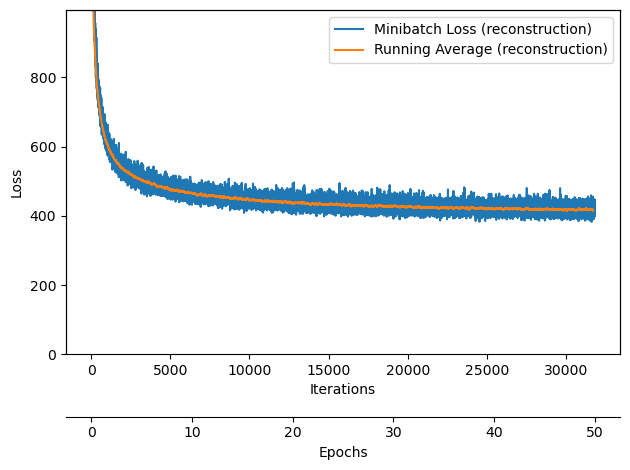

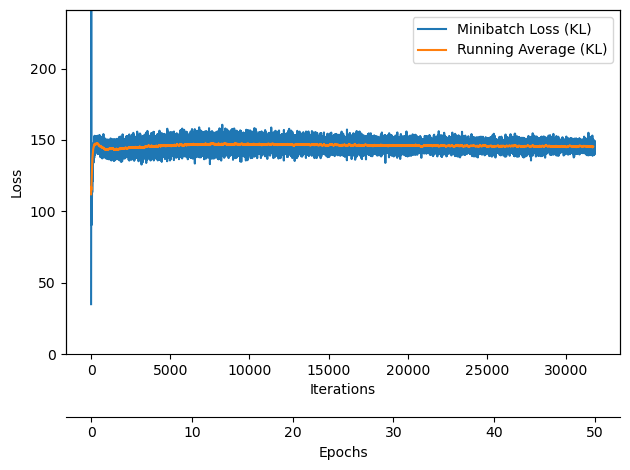

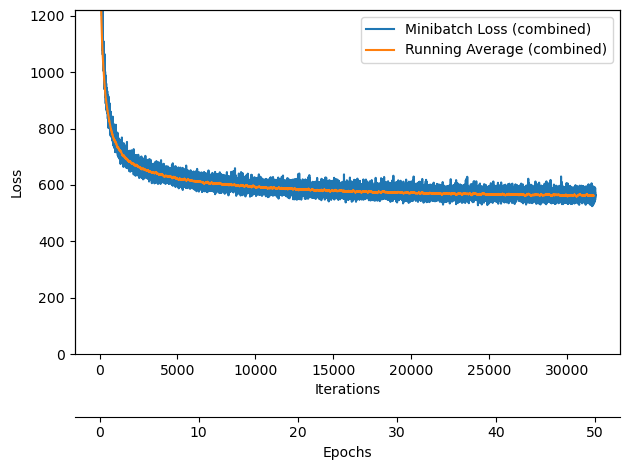

In [31]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()

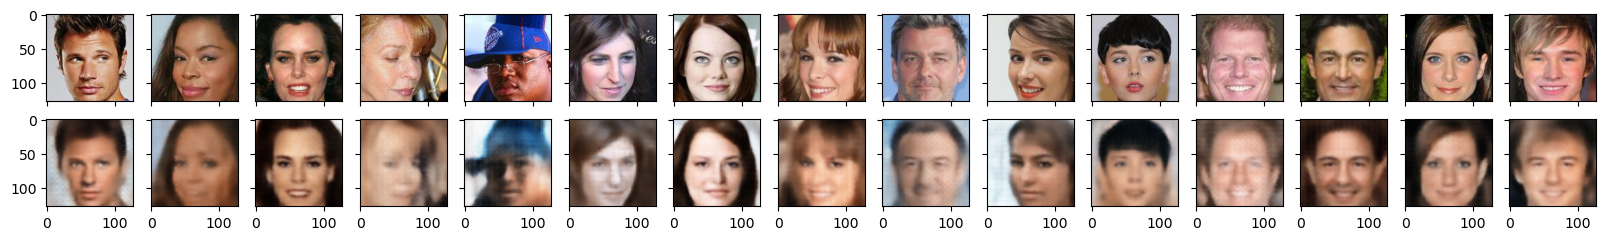

In [32]:
#unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
plot_generated_images(data_loader=train_loader,
                      model=model,
                      #unnormalizer=unnormalizer,
                      device=DEVICE,
                      modeltype='VAE')           

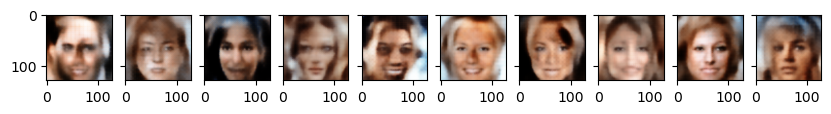

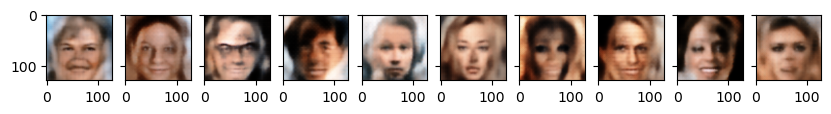

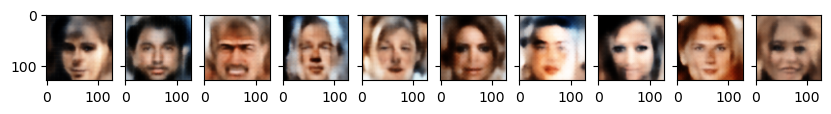

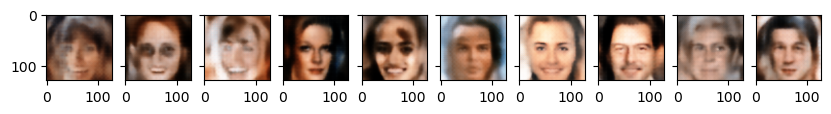

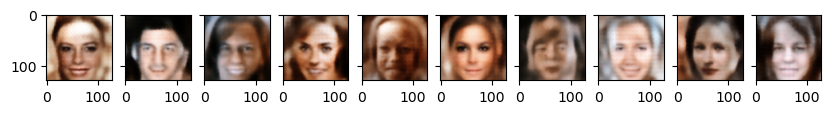

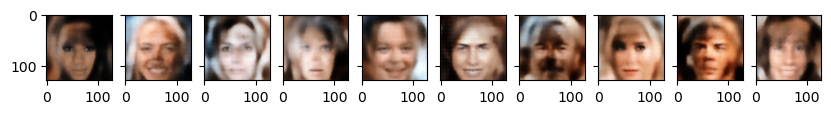

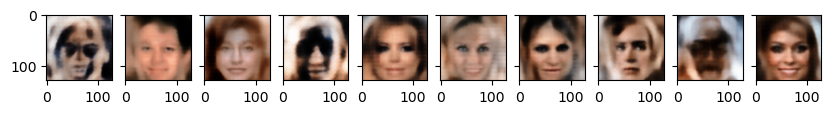

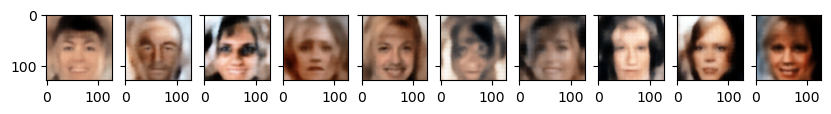

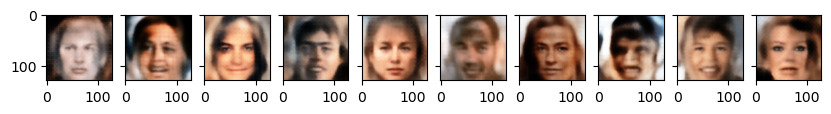

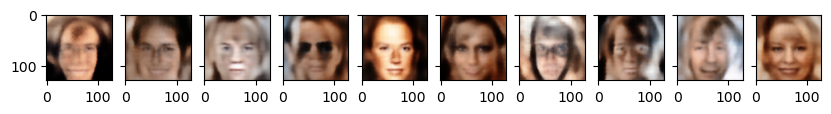

In [33]:
for i in range(10):
    plot_images_sampled_from_vae(model=model, device=DEVICE, latent_size=200)
    plt.show()